### Basemodel

In this notebook I take the data from the Happiness Index for a first basic model. I will try out different algorithms to decide which one performs best for the data. 

Target:
+ life_ladder  

Features:
+ log_gdp_per_capita


import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import happy_functions as haf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error 

read the data:

In [2]:
df = pd.read_csv("data/life_ladder_2005_2022_gdp_social.txt", delimiter=',')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

a short look into the content:

In [3]:
df.head(5)

,country_name,year,life_ladder,log_gdp_per_capita,social_support
0,Afghanistan,2008,3.724,7.350,0.451
1,Afghanistan,2009,4.402,7.509,0.552
2,Afghanistan,2010,4.758,7.614,0.539
3,Afghanistan,2011,3.832,7.581,0.521
4,Afghanistan,2012,3.783,7.661,0.521


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_name        2166 non-null   object 
 1   year                2166 non-null   int64  
 2   life_ladder         2166 non-null   float64
 3   log_gdp_per_capita  2166 non-null   float64
 4   social_support      2166 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 84.7+ KB


The data has already been cleansed. I can use it directly.  
  
Define Feature (X) and Target (y):

In [5]:
X = df[['log_gdp_per_capita']]
y = df['life_ladder']

In [6]:
print(X.shape, y.shape)

(2166, 1) (2166,)


Train-Test-Split:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1516, 1) (650, 1) (1516,) (650,)


Now I am testing which results different algorithms produce. 
The metric that is considered for the performance of the particular model is the mean absolute error (MAE).  

### Linear Regression
The first algorithm I want to test is linear regression. I will test this with different polynomials as parameters.   
At the end I will compare the MAE of the particular models for the train and the test data in a graph

In [8]:
lin_reg_error_lst = []
for i in range(1,11):
    polynomial_features = PolynomialFeatures(degree=i, include_bias=False)
    x_poly_train = polynomial_features.fit_transform(X_train)
    x_poly_test = polynomial_features.transform(X_test)

    lin_reg_poly = haf.train_model(LinearRegression, x_poly_train, y_train)

    lin_reg_error_lst.append({'model_name': 'linreg_poly_' + str(i),  
                      'train_mae': mean_absolute_error(y_train, lin_reg_poly.predict(x_poly_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, lin_reg_poly.predict(x_poly_test)).round(3)})

lin_reg_error_df = pd.DataFrame(lin_reg_error_lst)
lin_reg_error_df['delta_MAE'] = abs(lin_reg_error_df['train_mae'] - lin_reg_error_df['test_mae'])
lin_reg_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
7,linreg_poly_8,0.519,0.520,0.001
4,linreg_poly_5,0.529,0.530,0.001
6,linreg_poly_7,0.523,0.521,0.002
8,linreg_poly_9,0.519,0.515,0.004
0,linreg_poly_1,0.559,0.554,0.005
9,linreg_poly_10,0.520,0.512,0.008
5,linreg_poly_6,0.523,0.514,0.009
3,linreg_poly_4,0.546,0.537,0.009
1,linreg_poly_2,0.547,0.536,0.011
2,linreg_poly_3,0.547,0.536,0.011


graphical comparison (MAE)

/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


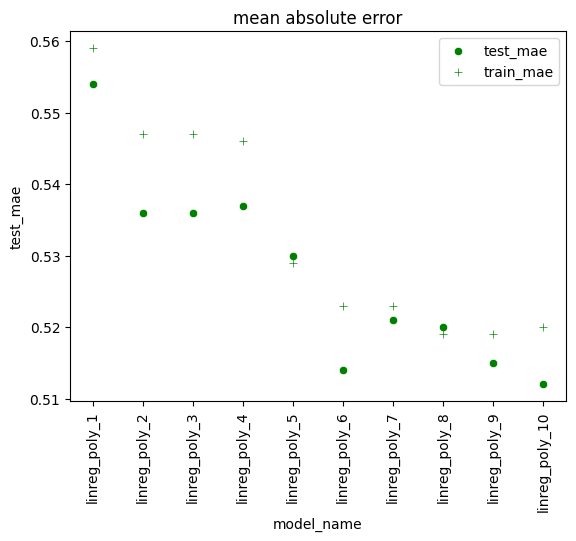

In [9]:
haf.scatter_mae_train_test_data(lin_reg_error_df)

The lowest MAEs are achieved on the degree 6 and the degree 10 model. But the delta between the mae_test and the mae_train is very high. So I also look at the points with lower delta. That is the case for degree 5, 7 and 8 model.   
I collect the metrics with the lowest delta in a new dataframe. It is for the comparison with the results from the other algorithm.

In [10]:
part_lin_reg = lin_reg_error_df.sort_values(by =['delta_MAE', 'test_mae']).iloc[:6]
part_lin_reg

,model_name,train_mae,test_mae,delta_MAE
7,linreg_poly_8,0.519,0.520,0.001
4,linreg_poly_5,0.529,0.530,0.001
6,linreg_poly_7,0.523,0.521,0.002
8,linreg_poly_9,0.519,0.515,0.004
0,linreg_poly_1,0.559,0.554,0.005
9,linreg_poly_10,0.520,0.512,0.008


### KNN

I the next step I will test the K-Nearest Neighbors Algorithm the same way.   
As parameter I will use a variable number of neighbors and variable distance metrics

In [11]:
knn_error_lst = []
for metr in range(1,4):
    for neigh in np.arange(5,55,5): 
        knn = haf.train_model(KNeighborsRegressor, X_train, y_train,n_neighbors=neigh, p=metr, weights='uniform' )
     
        knn_error_lst.append({'model_name': 'knn_' + str(metr) + '_' + str(neigh),  
                      'train_mae': mean_absolute_error(y_train, knn.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, knn.predict(X_test)).round(3)})
        
knn_error_df = pd.DataFrame(knn_error_lst)
knn_error_df['delta_MAE'] = abs(knn_error_df['train_mae'] - knn_error_df['test_mae'])
knn_error_df.sort_values(by = ['delta_MAE', 'test_mae']).head(7)

,model_name,train_mae,test_mae,delta_MAE
8,knn_1_45,0.504,0.506,0.002
9,knn_1_50,0.504,0.506,0.002
18,knn_2_45,0.504,0.506,0.002
19,knn_2_50,0.504,0.506,0.002
28,knn_3_45,0.504,0.506,0.002
29,knn_3_50,0.504,0.506,0.002
7,knn_1_40,0.503,0.506,0.003


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


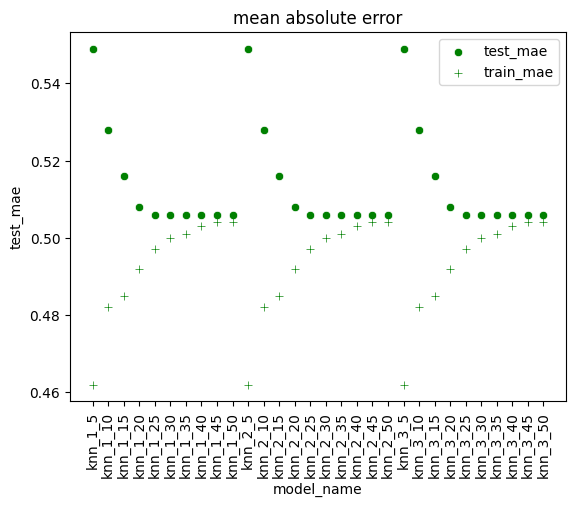

In [12]:
haf.scatter_mae_train_test_data(knn_error_df)

It should be noticed that I started with the range   
***metr in range(1,4)*** and   
***neigh in np.arange(5,50,5)***   
but then I could see that different distance metrics made no difference so I changed the parameter just to   
***metr in range(1,2)***

deswegen machen wir das jetzt noch einmal, aber nur mit einem metric usw.

In [13]:
knn_error_lst = []
for metr in range(1,2):
    for neigh in np.arange(10,55,5): 
        knn = haf.train_model(KNeighborsRegressor, X_train, y_train,n_neighbors=neigh, p=metr, weights='uniform' )
     
        knn_error_lst.append({'model_name': 'knn_' + str(metr) + '_' + str(neigh),  
                      'train_mae': mean_absolute_error(y_train, knn.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, knn.predict(X_test)).round(3)})
        
knn_error_df = pd.DataFrame(knn_error_lst)
knn_error_df['delta_MAE'] = abs(knn_error_df['train_mae'] - knn_error_df['test_mae'])
knn_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
7,knn_1_45,0.504,0.506,0.002
8,knn_1_50,0.504,0.506,0.002
6,knn_1_40,0.503,0.506,0.003
5,knn_1_35,0.501,0.506,0.005
4,knn_1_30,0.500,0.506,0.006
3,knn_1_25,0.497,0.506,0.009
2,knn_1_20,0.492,0.508,0.016
1,knn_1_15,0.485,0.516,0.031
0,knn_1_10,0.482,0.528,0.046


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


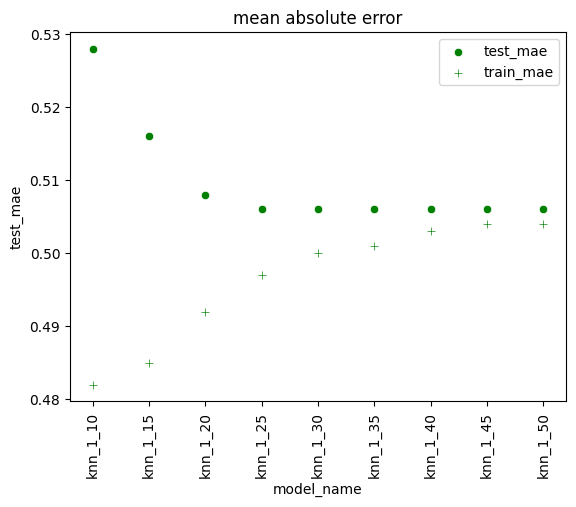

In [14]:
haf.scatter_mae_train_test_data(knn_error_df)

ich möchte alle 9 Werte für den vergleich mitnehmen:

In [15]:
part_knn = knn_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:9]
part_knn

,model_name,train_mae,test_mae,delta_MAE
7,knn_1_45,0.504,0.506,0.002
8,knn_1_50,0.504,0.506,0.002
6,knn_1_40,0.503,0.506,0.003
5,knn_1_35,0.501,0.506,0.005
4,knn_1_30,0.500,0.506,0.006
3,knn_1_25,0.497,0.506,0.009
2,knn_1_20,0.492,0.508,0.016
1,knn_1_15,0.485,0.516,0.031
0,knn_1_10,0.482,0.528,0.046


### Decision Tree

In [16]:
dectree_error_lst = []
for depth in np.arange(4,7,1):
    for leaf in np.arange(10,51,2): 
        dectree = haf.train_model(DecisionTreeRegressor, X_train, y_train,
                            max_depth = depth, 
                            max_leaf_nodes = leaf,
                            splitter = 'best')

        dectree_error_lst.append({'model_name': 'dectree_dep_' + str(depth) + '_max_leaf_' + str(leaf),  
                      'train_mae': mean_absolute_error(y_train, dectree.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, dectree.predict(X_test)).round(3)})
        
dectree_error_df = pd.DataFrame(dectree_error_lst)
dectree_error_df['delta_MAE'] = abs(dectree_error_df['train_mae'] - dectree_error_df['test_mae'])
dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_4_max_leaf_10,0.503,0.522,0.019
21,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
42,dectree_dep_6_max_leaf_10,0.503,0.522,0.019
23,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
22,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
...,...,...,...,...
56,dectree_dep_6_max_leaf_38,0.483,0.525,0.042
59,dectree_dep_6_max_leaf_44,0.481,0.524,0.043
60,dectree_dep_6_max_leaf_46,0.480,0.524,0.044
61,dectree_dep_6_max_leaf_48,0.480,0.524,0.044


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


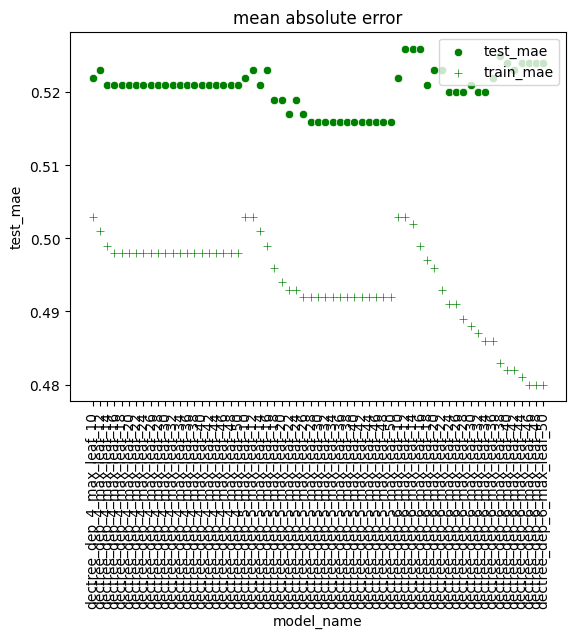

In [17]:
haf.scatter_mae_train_test_data(dectree_error_df)

In [18]:
dectree_error_lst = []
for depth in np.arange(4,7,1):
    for leaf in np.arange(10,31,2): 
        dectree = haf.train_model(DecisionTreeRegressor, X_train, y_train,
                            max_depth = depth, 
                            max_leaf_nodes = leaf,
                            splitter = 'best')

        dectree_error_lst.append({'model_name': 'dectree_dep_' + str(depth) + '_max_leaf_' + str(leaf),  
                      'train_mae': mean_absolute_error(y_train, dectree.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, dectree.predict(X_test)).round(3)})
        
dectree_error_df = pd.DataFrame(dectree_error_lst)
dectree_error_df['delta_MAE'] = abs(dectree_error_df['train_mae'] - dectree_error_df['test_mae'])
dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_4_max_leaf_10,0.503,0.522,0.019
11,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
22,dectree_dep_6_max_leaf_10,0.503,0.522,0.019
13,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
12,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
2,dectree_dep_4_max_leaf_14,0.499,0.521,0.022
1,dectree_dep_4_max_leaf_12,0.501,0.523,0.022
15,dectree_dep_5_max_leaf_18,0.496,0.519,0.023
3,dectree_dep_4_max_leaf_16,0.498,0.521,0.023
4,dectree_dep_4_max_leaf_18,0.498,0.521,0.023


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


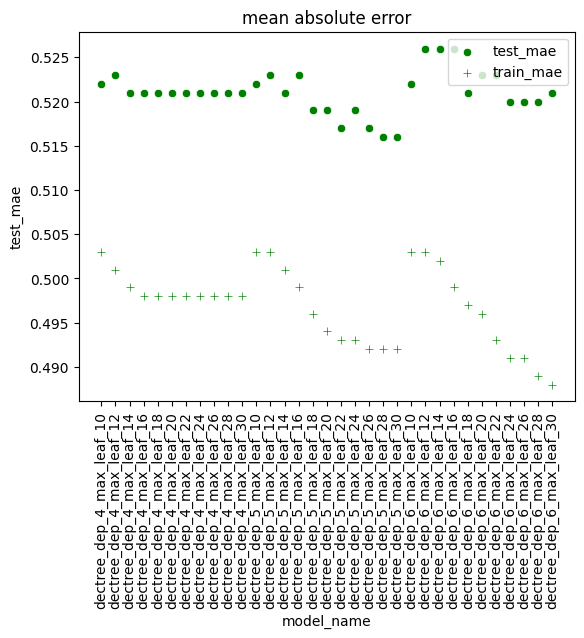

In [19]:
haf.scatter_mae_train_test_data(dectree_error_df)

In [20]:
part_dec_tree = dectree_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:6]
part_dec_tree

,model_name,train_mae,test_mae,delta_MAE
0,dectree_dep_4_max_leaf_10,0.503,0.522,0.019
11,dectree_dep_5_max_leaf_10,0.503,0.522,0.019
22,dectree_dep_6_max_leaf_10,0.503,0.522,0.019
13,dectree_dep_5_max_leaf_14,0.501,0.521,0.020
12,dectree_dep_5_max_leaf_12,0.503,0.523,0.020
2,dectree_dep_4_max_leaf_14,0.499,0.521,0.022


### Random Forest

In [21]:
random_trees_error_lst = []
for tree_depth in [3, 5, 7]:
    for tree_leaf in np.arange(5,55,5): 
        random_forest = haf.train_model(RandomForestRegressor, X_train, y_train,
                            n_estimators=100, 
                            random_state=123, 
                            max_depth = tree_depth,
                            max_leaf_nodes = tree_leaf,
                            max_features = 'sqrt',
                            n_jobs=-1, verbose = 1)
        
        n_nodes = []
        maximum_depths = []
        for tree_idx in random_forest.estimators_:
            n_nodes.append(tree_idx.tree_.node_count)
            maximum_depths.append(tree_idx.tree_.max_depth)
        
        mean_node_num = int(np.mean(n_nodes))
        mean_depth = int(np.mean(maximum_depths))
        num_of_trees = len(random_forest.estimators_)

        random_trees_error_lst.append({'model_name': 'forest_tree_depth' + str(tree_depth) + '_max_leaf_' + str(tree_leaf),  
                      'train_mae': mean_absolute_error(y_train, random_forest.predict(X_train)).round(3), 
                      'test_mae': mean_absolute_error(y_test, random_forest.predict(X_test)).round(3),
                      'mean_node_num': mean_node_num,
                      'mean_depth': mean_depth,
                      'num_of_trees': num_of_trees})
        
random_trees_error_df = pd.DataFrame(random_trees_error_lst)
random_trees_error_df['delta_MAE'] = abs(random_trees_error_df['train_mae'] - random_trees_error_df['test_mae'])
random_trees_error_df.sort_values(by = ['delta_MAE', 'test_mae'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel

,model_name,train_mae,test_mae,mean_node_num,mean_depth,num_of_trees,delta_MAE
1,forest_tree_depth3_max_leaf_10,0.504,0.516,15,3,100,0.012
2,forest_tree_depth3_max_leaf_15,0.504,0.516,15,3,100,0.012
3,forest_tree_depth3_max_leaf_20,0.504,0.516,15,3,100,0.012
4,forest_tree_depth3_max_leaf_25,0.504,0.516,15,3,100,0.012
5,forest_tree_depth3_max_leaf_30,0.504,0.516,15,3,100,0.012
6,forest_tree_depth3_max_leaf_35,0.504,0.516,15,3,100,0.012
7,forest_tree_depth3_max_leaf_40,0.504,0.516,15,3,100,0.012
8,forest_tree_depth3_max_leaf_45,0.504,0.516,15,3,100,0.012
9,forest_tree_depth3_max_leaf_50,0.504,0.516,15,3,100,0.012
11,forest_tree_depth5_max_leaf_10,0.499,0.516,19,4,100,0.017


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


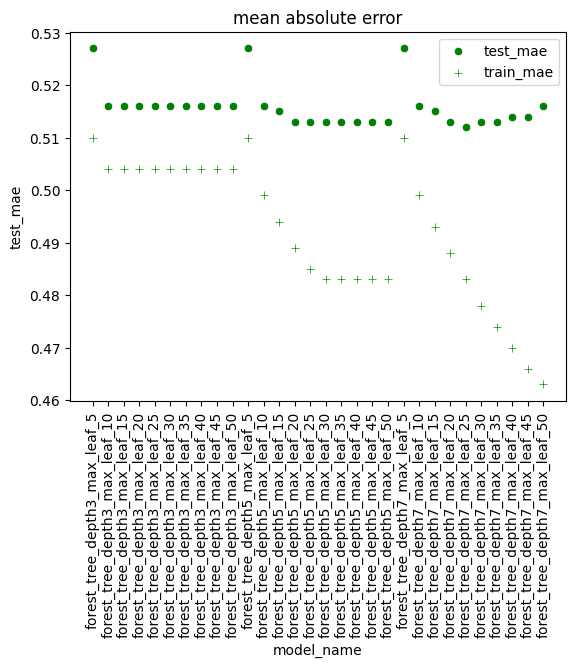

In [22]:
haf.scatter_mae_train_test_data(random_trees_error_df)

In [23]:
part_forest = random_trees_error_df.sort_values(by = ['delta_MAE', 'test_mae']).iloc[:6]
part_forest

,model_name,train_mae,test_mae,mean_node_num,mean_depth,num_of_trees,delta_MAE
1,forest_tree_depth3_max_leaf_10,0.504,0.516,15,3,100,0.012
2,forest_tree_depth3_max_leaf_15,0.504,0.516,15,3,100,0.012
3,forest_tree_depth3_max_leaf_20,0.504,0.516,15,3,100,0.012
4,forest_tree_depth3_max_leaf_25,0.504,0.516,15,3,100,0.012
5,forest_tree_depth3_max_leaf_30,0.504,0.516,15,3,100,0.012
6,forest_tree_depth3_max_leaf_35,0.504,0.516,15,3,100,0.012


In [24]:
error_df = pd.concat([part_lin_reg, 
                      part_knn,
                      part_dec_tree,
                      part_forest],  axis = 0)
                      
error_df.sort_values(by = ['delta_MAE', 'test_mae'])

,model_name,train_mae,test_mae,delta_MAE,mean_node_num,mean_depth,num_of_trees
7,linreg_poly_8,0.519,0.520,0.001,NaN,NaN,NaN
4,linreg_poly_5,0.529,0.530,0.001,NaN,NaN,NaN
7,knn_1_45,0.504,0.506,0.002,NaN,NaN,NaN
8,knn_1_50,0.504,0.506,0.002,NaN,NaN,NaN
6,linreg_poly_7,0.523,0.521,0.002,NaN,NaN,NaN
6,knn_1_40,0.503,0.506,0.003,NaN,NaN,NaN
8,linreg_poly_9,0.519,0.515,0.004,NaN,NaN,NaN
5,knn_1_35,0.501,0.506,0.005,NaN,NaN,NaN
0,linreg_poly_1,0.559,0.554,0.005,NaN,NaN,NaN
4,knn_1_30,0.500,0.506,0.006,NaN,NaN,NaN


/Users/maritaschmidt/NEUE_FISCHE/playing_around/happy_functions.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


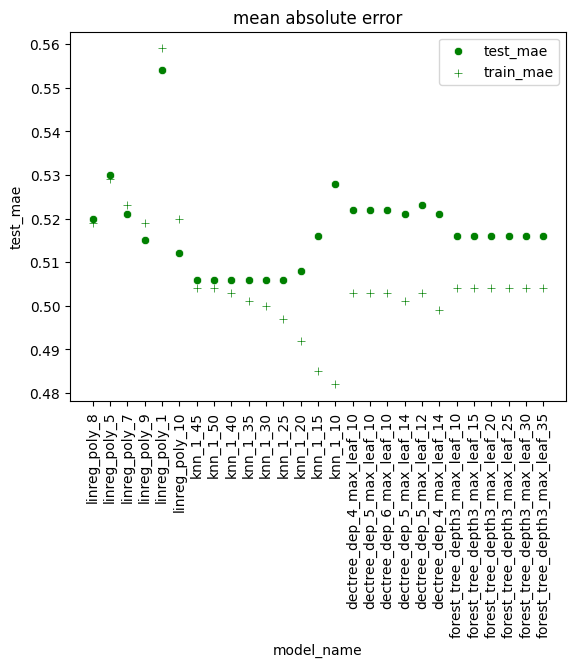

In [25]:
haf.scatter_mae_train_test_data(error_df)